# Observation

## Quickly inspect data

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

ds = xr.open_dataset('../data/sst.mnmean.nc')  # ERSSTv5 typically has lon 0..360
ds.keys

<bound method Mapping.keys of <xarray.Dataset> Size: 132MB
Dimensions:    (lat: 89, lon: 180, time: 2059, nbnds: 2)
Coordinates:
  * lat        (lat) float32 356B 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0
  * lon        (lon) float32 720B 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2025-07-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 33kB ...
    sst        (time, lat, lon) float32 132MB ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ..

In [2]:
import hvplot.xarray
import holoviews as hv
hv.extension('bokeh')
# %matplotlib inline

%output holomap='scrubber' fps=3
ds.sst.hvplot('lon', 'lat', cmap='RdBu_r').redim.range(sst=(-2, 30))

/tmp/ipykernel_1031043/1422216783.py:6: HoloviewsDeprecationWarning: IPython magic is deprecated and will be removed in version 1.23.0.
  get_ipython().run_line_magic('output', "holomap='scrubber' fps=3")


:DynamicMap   [time]
   :Image   [lon,lat]   (Monthly Means of Sea Surface Temperature)

## PCA

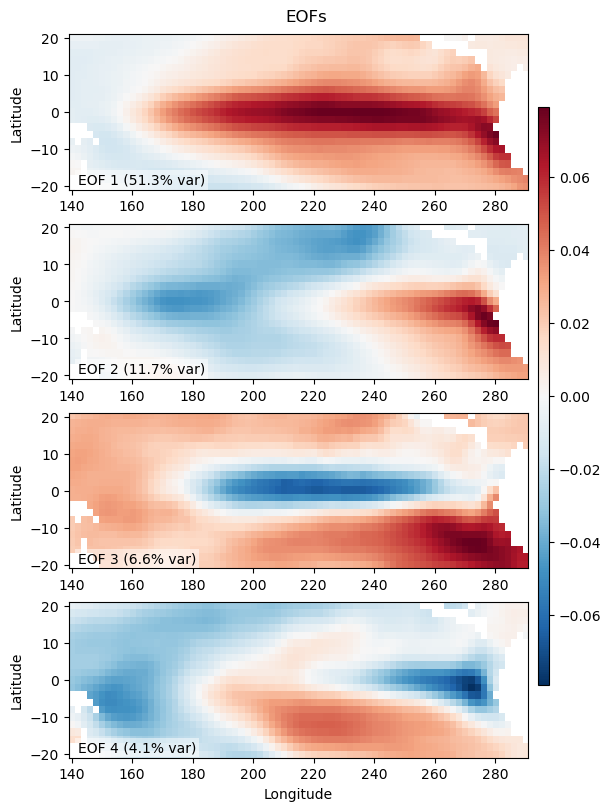

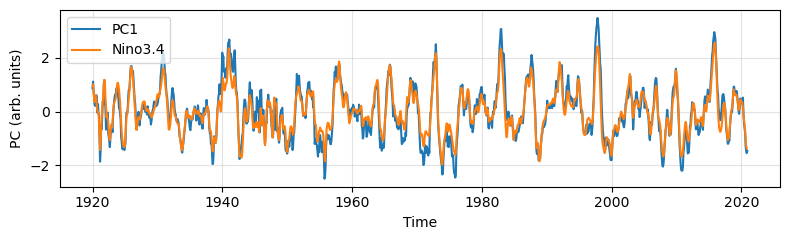

In [10]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import detrend as sp_detrend
import hvplot.xarray
import holoviews as hv
hv.extension('bokeh')
from eofs.xarray import Eof

def pca_ersstv5(
    da,
    time_slice=None,        # e.g. ("1900-01", "2024-12")
    lat_bounds=None,        # e.g. (60, -60)
    lon_bounds=None,        # e.g. (120, 290)   (0..360 in ERSST)
    remove_season=True,
    detrend_linear=False,
    n_modes=10,
    reorder_lat_ascending=False,
    nino=False,
    clim_ref=None,
):
    # ---- (Optional) reorder latitude to ascending; safer for weighting/plots ---
    if reorder_lat_ascending and (da.lat.values[0] > da.lat.values[-1]):
        da = da.sortby("lat")

    # ---- Subset time ----
    if time_slice is not None:
        da = da.sel(time=slice(*time_slice))

    # ---- Subset latitude ----
    if lat_bounds is not None:
        lo, hi = lat_bounds
        da = da.sel(lat=slice(lo, hi))

    # ---- Subset longitude ----
    if lon_bounds is not None:
        lo, hi = lon_bounds
        if lo <= hi:
            da = da.sel(lon=slice(lo, hi))
        else:
            # wrap-around case, e.g. (300, 60)
            da = xr.concat(
                [da.sel(lon=slice(lo, 360)), da.sel(lon=slice(0, hi))],
                dim="lon"
            )

    # ---- Remove seasonal cycle (monthly climatology) ----
    if remove_season:
        if clim_ref is None:
            clim = da.groupby("time.month").mean("time")
        else:
            ref = da.sel(time=slice(*clim_ref)) # Select the reference period for climatology
            if ref.time.size == 0:
                raise ValueError(f"clim_ref range {clim_ref} has no overlap with data.")
            clim = ref.groupby("time.month").mean("time") # Compute monthly climatology over the reference period
        anoms = da.groupby("time.month") - clim # Subtract monthly climatology from all time steps
    else:
        anoms = da        

    # ---- (Optional) linear detrend per grid cell ----
    if detrend_linear:
        def _detrend_1d(x):
            if np.all(np.isnan(x)):
                return x
            return sp_detrend(x, type="linear")
        anoms = xr.apply_ufunc(
            _detrend_1d, anoms,
            input_core_dims=[["time"]],
            output_core_dims=[["time"]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[anoms.dtype]
        )

    # ---- (Optional) Nino 3.4 ----
    if nino == True:
        nino34_xy = anoms.sel(lat=slice(5, -5), lon=slice(190, 240))
        nino34_mean = nino34_xy.mean(dim=('lon', 'lat'))
        nino34 = nino34_mean.rolling(time=3, center=True).mean()
    else:
        nino34 = None
    
    # ---- Area weights: sqrt(cos(lat))  (broadcast over lon) ----
    lat_rad = np.deg2rad(anoms["lat"])
    w_lat = np.sqrt(np.cos(lat_rad))
    w2d = w_lat.broadcast_like(anoms.isel(time=0)) # Expand to 2D (lat, lon) for clean broadcasting
    
    # anoms_w = anoms * w2d
    # anoms_w = anoms_w[:, np.isfinite(anoms_w).all("time")]
    # anoms_w.mean(dim=['lon', 'lat']).plot(label='detrended')
    # plt.grid()
    # plt.legend()

    solver = Eof(anoms.transpose("time", "lat", "lon"), weights=w2d)
    EOFs = solver.eofs(neofs=n_modes)
    PCs = solver.pcs(npcs=n_modes, pcscaling=1)
    evrs = solver.varianceFraction()
    EOFs = EOFs.assign_coords(mode=np.arange(1, EOFs.sizes["mode"]+1))

    out = {
        "EOFs": EOFs,  # [mode, lat, lon] in °C units
        "PCs": xr.DataArray(PCs, coords={"time": anoms["time"], "mode": np.arange(1, n_modes+1)}, dims=["time","mode"]),
        "evrs": xr.DataArray(evrs[:n_modes], coords={"mode": np.arange(1, n_modes+1)}, dims=["mode"]),
        # "singular_values": s[:k],
        "anoms": anoms,
        "lat": anoms["lat"],
        "lon": anoms["lon"],
        "time": anoms["time"],
        "nino34": nino34,
    }
    return out

def plot_eofs(eofs, evr, modes=(1,2,3), vmin=None, vmax=None):
    modes = list(modes)
    fig, axs = plt.subplots(len(modes), 1, figsize=(6, 2*len(modes)), constrained_layout=True)
    if len(modes) == 1: axs = [axs]
    for ax, m in zip(axs, modes):
        patt = eofs.sel(mode=m)
        patt = patt.sortby("lat")
        im = patt.plot.imshow(
            ax=ax, cmap="RdBu_r", vmin=vmin, vmax=vmax,
            add_colorbar=False
        )
        ax.set_title("")
        ax.text(
            0.02, 0.02, f"EOF {m} ({evr.sel(mode=m).item()*100:.1f}% var)",
            transform=ax.transAxes, fontsize=10,
            color="black", ha="left", va="bottom",
            bbox=dict(facecolor="white", alpha=0.5, edgecolor="none", pad=2)
        )
        if ax != axs[-1]:
            ax.set_xlabel("")
        else: 
            ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

    cbar = fig.colorbar(im, ax=axs, orientation="vertical", aspect=50, shrink=0.8, fraction=0.1, pad=0.02)
    fig.suptitle("EOFs", fontsize=12)
def plot_pcs(pcs, modes=(1,2,3), nino=None):
    fig, ax = plt.subplots(figsize=(8, 2.5))
    for m in modes:
        ax.plot(pcs["time"].values, pcs.sel(mode=m), label=f"PC{m}")
    if nino is not None:
        ax.plot(nino["time"].values, nino, label=f"Nino3.4")
    ax.legend()
    ax.grid(True, alpha=0.35)
    ax.set_xlabel("Time")
    ax.set_ylabel("PC (arb. units)")
    plt.tight_layout()
    plt.show()
    
if __name__ == "__main__":
    #ds = xr.open_dataset("../ENSO-data/data/sst.mnmean.nc")
    ds = xr.open_dataset("../data/sst.mnmean.nc")
    da = ds["sst"]  # ERSSTv5: 'sst'
    res = pca_ersstv5(
        da,
        time_slice=("1920-01", "2020-12"),
        lat_bounds=(20, -20),
        lon_bounds=(140, 290),
        remove_season=True,
        detrend_linear=True,
        n_modes=4,
        nino=True,
        clim_ref=("1981-01", "2010-12"),
    )

    plot_eofs(res["EOFs"], res["evrs"], modes=(1,2,3,4))
    # plt.savefig('../figure/eofs.png')
    plot_pcs(res["PCs"], modes=(1,), nino=res['nino34'])

In [13]:
ds_out = xr.Dataset(
    data_vars={
        "EOFs":   res["EOFs"],     # (mode, lat, lon)
        "PCs":    res["PCs"],      # (time, mode)
        "EVRs":    res["evrs"],     # (mode)
        "Nino34": res["nino34"],   # (time)
        "anoms":   res["anoms"],    # (time, lat, lon) anomalies used in EOFs
    }
)
ds_out.attrs.update({
    "title": "ERSSTv5 EOF/PCA and Niño 3.4",
    "climatology_ref": "1981-01 to 2010-12",
    "notes": "EOFs computed with eofs.xarray, weights = sqrt(cos(lat))",
})

out_path = "../data/ersstv5_eof_nino34_1920_2020.nc"
ds_out.to_netcdf(out_path, format="NETCDF4")
print(f"Saved to {out_path}")

Saved to ../data/ersstv5_eof_nino34_1920_2020.nc


In [17]:
res["PCs"].to_numpy().shape

(1212, 4)

## Clustering

### FCM

In [35]:
import numpy as np
import xarray as xr
from sklearn.preprocessing import StandardScaler
from cluster import FCMEntropy
from time import time
import pickle

def reorder_labels_by_mean_nino34(nino34, labels):
    """
    Reorder integer labels so that the highest-mean Niño 3.4
    regime is label 0, next highest is label 1, etc.
    """
    labels = np.asarray(labels)
    nino34 = np.asarray(nino34)

    unique_labels = np.unique(labels)
    means = {lab: np.nanmean(nino34[labels == lab]) for lab in unique_labels}

    # Sort regime IDs by descending mean Niño 3.4
    sorted_labs = sorted(unique_labels, key=lambda x: means[x], reverse=True)

    # Map old label -> new label (0, 1, 2, ...)
    remap = {old: new for new, old in enumerate(sorted_labs)}
    new_labels = np.array([remap[lab] for lab in labels])

    return new_labels, remap, means
    
np.random.seed(0)

########################## load data ############################
file = xr.open_dataset("../data/ersstv5_eof_nino34_1920_2020.nc")
data = file["PCs"].to_numpy()
nino34 = file["Nino34"].to_numpy()
train_size = 1212 # training data size
test_size = 0 # test data size

######################### clustering ############################
K = 5 # number of clusters (regimes)
L = 0 # time delay steps
data = data[:train_size]
Nt, _ = data.shape
features = []
features.append(data)
data_embedded = np.concatenate(features, axis=1)

# standardize features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_embedded)

# clustering
cluster_model = FCMEntropy(num_clusters=K, m=1.8, lambda_e=.2, num_steps=1000, seed=0)
results = cluster_model.fit(data_scaled, optimizer='iterative')
membership = results['membership']
centers = results['centers']
labels = np.argmax(membership, axis=1)
new_labels, remap, means = reorder_labels_by_mean_nino34(nino34, labels)

# save the clustering model
fcm_model_data = {
    'centers': cluster_model.centers,
    'weights': cluster_model.weights,
    'scaler': scaler,
    'config': {
        'num_clusters': cluster_model.num_clusters,
        'm': cluster_model.m,
        'lambda_e': cluster_model.lambda_e,
    }}
with open('../data/fcm_ersstv5.pkl', 'wb') as f:
    pickle.dump(fcm_model_data, f)

In [5]:
data_embedded.shape

(1212, 4)

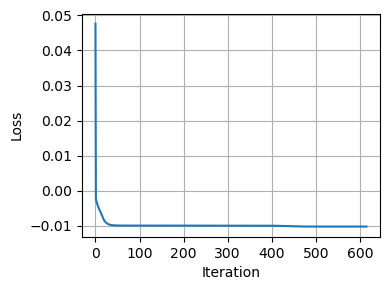

In [36]:
from plot import plot_loss
loss_history = results['loss_history']
plot_loss(loss_history)

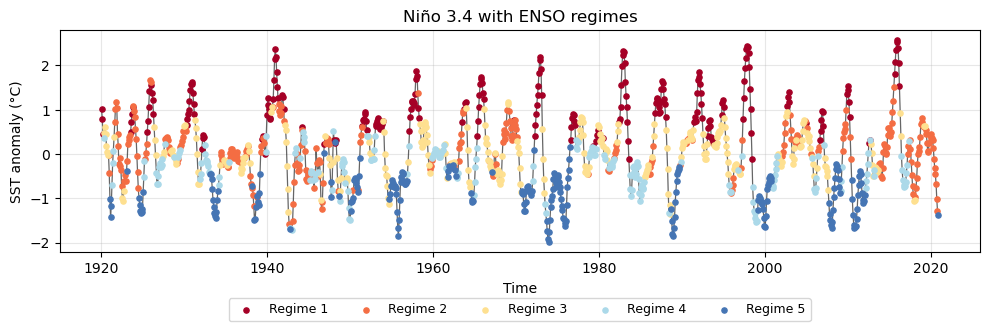

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

def plot_nino34_with_regimes(
    nino34,                   # np.ndarray, shape (Nt,)
    labels,                   # np.ndarray or list, shape (Nt,), ints like 0..K-1 (or -1 for noise)
    time=None,                # None, np.ndarray shape (Nt,), or pandas.DatetimeIndex
    regime_names=None,        # list of names per regime id; len==K
    colors=None,              # list of color strings per regime id; len==K
    rolling=None,             # e.g., 3 or 5 for moving avg window (optional)
    title="Niño 3.4 with clustered regimes"
):
    nino34 = np.asarray(nino34)
    labels = np.asarray(labels)
    assert nino34.shape == labels.shape, "nino34 and labels must have same shape"
    Nt = nino34.size
    if time is None:
        x = np.arange(Nt)
        xlabel = "Time index"
    else:
        x = np.asarray(time)
        xlabel = "Time"
        
    # Handle NaNs: mask both arrays consistently
    good = np.isfinite(nino34) & np.isfinite(labels)
    x_plot = x[good]
    y_plot = nino34[good]
    lab_plot = labels[good].astype(int)

    # Unique regimes (keep order by sorted)
    uniq = np.unique(lab_plot)

    # Build colors
    assert len(colors) >= len(uniq), "Provide enough colors for all regimes"
    palette = colors[:len(uniq)]

    # Map regime id -> color (keep label ids)
    color_map = {lab: palette[i] for i, lab in enumerate(uniq)}

    # Build names
    name_map = {lab: (regime_names[lab] if lab >= 0 else "Noise") for lab in uniq} # If regime ids start at 0..K-1, map directly; for -1 keep "Noise"

    fig, ax = plt.subplots(figsize=(10, 3.5))
    ax.plot(x, nino34, 'k', lw=0.9, alpha=0.6)
    for lab in uniq:
        sel = lab_plot == lab
        ax.scatter(x_plot[sel], y_plot[sel], s=14, color=color_map[lab], label=name_map[lab], zorder=3)
    ax.set_ylabel("SST anomaly (°C)")
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

    # Deduplicate legend entries (Niño line, rolling mean, regimes)
    handles, labels_ = ax.get_legend_handles_labels()
    seen = {}
    new_h, new_l = [], []
    for h, l in zip(handles, labels_):
        if l not in seen:
            seen[l] = True
            new_h.append(h); new_l.append(l)
    ax.legend(new_h, new_l, ncol=2, fontsize=9)
    # Legend outside bottom
    ax.legend(
        new_h, new_l,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.18),
        ncol=len(new_l),
        fontsize=9
    )

    plt.tight_layout()
    return fig, ax

colors = [
    "#a50026",  # deep red
    "#f46d43",  # orange-red
    "#fee090",  # light orange
    "#abd9e9",  # light blue
    "#4575b4",  # deep blue
]
fig, ax = plot_nino34_with_regimes(
    nino34, new_labels, time=file["time"],  # times can be pandas.DatetimeIndex
    regime_names=["Regime 0", "Regime 1", "Regime 2", "Regime 3", "Regime 4"],
    colors=colors,
    title="Niño 3.4 with ENSO regimes"
)
plt.savefig('../figure/nino34_regimes_fcm.png')
plt.show()


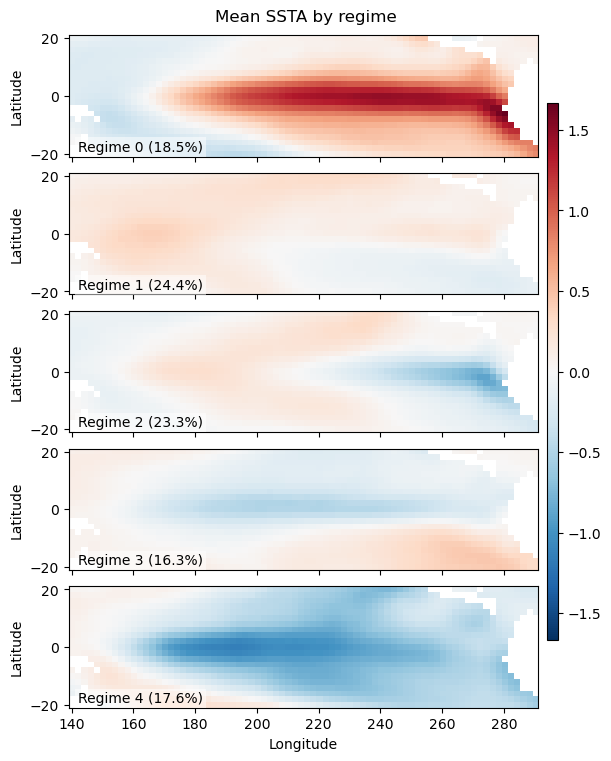

In [15]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def mean_anom_per_regime(anom: xr.DataArray, regime_ids):
    # Ensure time is the first dim (xarray's groupby alignment will use coords anyway)
    if anom.dims[0] != "time":
        anom = anom.transpose("time", ...)

    # Make a time-aligned DataArray of regime labels
    reg = xr.DataArray(
        np.asarray(regime_ids),
        coords={"time": anom["time"]},
        dims=["time"],
        name="regime"
    )

    # Group by regime and average over time
    mean_maps = anom.groupby(reg).mean("time")  # dims -> ('regime','lat','lon')

    # Make sure the regime dim is nicely named and sorted
    mean_maps = mean_maps.rename({"regime": "regime"}).sortby("regime")
    
    # Frequency per regime
    counts = reg.groupby(reg).count()           # -> (regime,)
    counts = counts.rename("count").sortby("regime")
    total  = int(reg.count().item())
    freq   = (counts / total).rename("freq")    # fraction in [0,1]

    return mean_maps, freq  # (regime, lat, lon)

def plot_five_regime_means(mean_maps: xr.DataArray, freq: xr.DataArray, regimes=None, cmap="RdBu_r"):
    """
    Plot five regime-mean anomaly maps with a shared symmetric color scale.
    If 'regimes' is None, the first five regimes in mean_maps.regime are used.
    """
    if regimes is None:
        regimes = mean_maps.regime.values[:5]
    sel = mean_maps.sel(regime=regimes)

    vmax = float(np.nanmax(np.abs(sel.values)))
    vmin = -vmax

    fig, axs = plt.subplots(
        len(regimes), 1, figsize=(6, 1.5*len(regimes)),
        sharex=True, constrained_layout=True
    )

    if len(regimes) == 1:
        axs = [axs]
        
    frq_map = {int(r): float(freq.sel(regime=r).item()) for r in freq.regime.values}

    for ax, reg in zip(axs, regimes):
        patt = sel.sel(regime=reg)
        im = patt.plot.imshow(
            ax=ax,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            add_colorbar=False
        )
        ax.set_ylabel("Latitude")
        if ax != axs[-1]:
            ax.set_xlabel("")
        else: 
            ax.set_xlabel("Longitude")
        ax.set_title("")  # remove any auto-generated title
        r = int(reg)
        frq = frq_map.get(r, 0.0) * 100.0
        ax.text(
            0.02, 0.02, f"Regime {reg} ({frq:.1f}%)",
            transform=ax.transAxes, fontsize=10,
            color="black", ha="left", va="bottom",
            bbox=dict(facecolor="white", alpha=0.5, edgecolor="none", pad=2)
        )

    cbar = fig.colorbar(im, ax=axs, orientation="vertical", aspect=50, shrink=0.8, fraction=0.1, pad=0.02)
    fig.suptitle("Mean SSTA by regime", fontsize=12)

mean_maps, freq = mean_anom_per_regime(file["anoms"], new_labels)
plot_five_regime_means(mean_maps, freq, regimes=[0,1,2,3,4])
plt.savefig('../figure/meanssta_regimes_fcm.png')
plt.show()

# Models

## Preprocessing

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
ds = xr.open_dataset("../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014.nc")
ds.keys

<bound method Mapping.keys of <xarray.Dataset> Size: 79MB
Dimensions:           (time: 1980, bound: 2, latitude: 50, longitude: 200)
Coordinates:
  * time              (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014...
  * latitude          (latitude) float64 400B -24.5 -23.5 -22.5 ... 23.5 24.5
  * longitude         (longitude) float64 2kB 100.5 101.5 102.5 ... 298.5 299.5
Dimensions without coordinates: bound
Data variables:
    time_bnds         (time, bound) datetime64[ns] 32kB ...
    bounds_latitude   (latitude, bound) float64 800B ...
    bounds_longitude  (longitude, bound) float64 3kB ...
    sst               (time, latitude, longitude) float32 79MB ...
    ts_glob           (time) float32 8kB ...
    ts_trop           (time) float32 8kB ...
Attributes: (12/48)
    EnsoMetrics_disclaimer:                    The results in this file were ...
    original_attribute_activity_id:            CMIP
    original_attribute_branch_method:          standard
    original_attribut

In [2]:
import hvplot.xarray
import holoviews as hv
hv.extension('bokeh')
# %matplotlib inline

%output holomap='scrubber' fps=3
ds.sel(time=slice("1920-01", "2020-12")).sst.hvplot('longitude', 'latitude', cmap='RdBu_r').redim.range(sst=(-2, 30))

/tmp/ipykernel_3508585/816614438.py:6: HoloviewsDeprecationWarning: IPython magic is deprecated and will be removed in version 1.23.0.
  get_ipython().run_line_magic('output', "holomap='scrubber' fps=3")


:DynamicMap   [time]
   :Image   [longitude,latitude]   (sst)

In [3]:
ds.sst

<xarray.DataArray 'sst' (time: 1980, latitude: 50, longitude: 200)> Size: 79MB
[19800000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
  * latitude   (latitude) float64 400B -24.5 -23.5 -22.5 ... 22.5 23.5 24.5
  * longitude  (longitude) float64 2kB 100.5 101.5 102.5 ... 297.5 298.5 299.5
Attributes:
    original_attribute_comment:        Temperature of the lower boundary of t...
    original_attribute_long_name:      Surface Temperature
    original_attribute_standard_name:  surface_temperature
    original_attribute_units:          K
    original_attribute_variable_name:  ts
    EnsoMetrics_operation:             1) TS (Surface Temperature (skin for o...
    EnsoMetrics_variable_calculation:  ts - 273.15
    EnsoMetrics_standard_name:         sea_surface_temperature
    EnsoMetrics_long_name:             Sea Surface Temperature
    EnsoMetrics_units:                 degC
    EnsoMetrics_variable_name:         sst

Since model data has different spatial grids from the reanalysis data, coarsening and averaging are needed to align the spatial grids.

In [4]:
# Coarsening data
# Ensure longitudes are 0–360 and sorted
if ds.longitude.max() <= 180:
    ds = ds.assign_coords(lon=(ds.lon % 360)).sortby('longitude')
else:
    ds = ds.sortby('longitude')

# 1) Expand the subset by 0.5° so 2x2 blocks will be centered on integers
#    lat bins: [-20.5, -19.5] -> -20, [-18.5, -17.5] -> -18, ..., [19.5, 20.5] -> 20
#    lon bins: [139.5, 140.5] -> 140, ..., [289.5, 290.5] -> 290
ds_block = ds.sel(latitude=slice(-20.5, 20.5), longitude=slice(139.5, 290.5))

# 2) Coarsen to 2°×2° by averaging 2×2 cells
ds_2deg = ds_block.coarsen(latitude=2, longitude=2, boundary='trim').mean()

# 3) Set the coarsened coordinates to the mean-of-blocks (these will be integers)
lat_new = ds_block['latitude'].coarsen(latitude=2, boundary='trim').mean()
lon_new = ds_block['longitude'].coarsen(longitude=2, boundary='trim').mean()
ds_2deg = ds_2deg.assign_coords(latitude=lat_new, longitude=lon_new)

ds_2deg = ds_2deg.sortby('latitude', ascending=False)

In [5]:
ds_2deg

<xarray.Dataset> Size: 13MB
Dimensions:           (time: 1980, bound: 2, latitude: 21, longitude: 76)
Coordinates:
  * time              (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014...
  * latitude          (latitude) float64 168B 20.0 18.0 16.0 ... -18.0 -20.0
  * longitude         (longitude) float64 608B 140.0 142.0 144.0 ... 288.0 290.0
Dimensions without coordinates: bound
Data variables:
    time_bnds         (time, bound) datetime64[ns] 32kB 1850-01-01 ... 2015-0...
    bounds_latitude   (latitude, bound) float64 336B 19.5 20.5 ... -20.5 -19.5
    bounds_longitude  (longitude, bound) float64 1kB 139.5 140.5 ... 289.5 290.5
    sst               (time, latitude, longitude) float32 13MB 24.46 ... nan
    ts_glob           (time) float32 8kB 13.02 13.06 14.05 ... 15.8 14.86 14.29
    ts_trop           (time) float32 8kB 25.12 25.46 25.91 ... 26.57 26.27 25.98
Attributes: (12/48)
    EnsoMetrics_disclaimer:                    The results in this file were ...
    original_attribute_activity_id:            CMIP
    original_attribute_branch_method:          standard
    original_attribute_branch_time_in_child:   0.0
    original_attribute_branch_time_in_parent:  0.0
    original_attribute_calendar:               proleptic_gregorian
    ...                                        ...
    original_attribute_table_info:             Creation Date:(30 April 2019) ...
    original_attribute_title:                  ACCESS-CM2 output prepared for...
    original_attribute_tracking_id:            hdl:21.14100/246cb7d2-3eb7-412...
    original_attribute_variable_id:            ts
    original_attribute_variant_label:          r1i1p1f1
    original_attribute_version:                v20191108

In [6]:
ds_2deg.sel(time=slice("1920-01", "2020-12")).sst.hvplot('longitude', 'latitude', cmap='RdBu_r').redim.range(sst=(-2, 30))

:DynamicMap   [time]
   :Image   [longitude,latitude]   (sst)

## Clustering 

First compute 'pseudo-PCs' by projecting the model data to the EOFs of reanalysis data.

In [42]:
import numpy as np
import xarray as xr

def compute_pcs(data: xr.DataArray,
                eofs: xr.DataArray,
                lat_name: str = "lat",
                lon_name: str = "lon",    
                remove_season=True,
                detrend_linear=True,
                clim_ref=None,
                nino = False,
                pcscaling = 1,
                weight: str = "cos") -> xr.DataArray:
    """
    Compute principal components (PCs) by projecting data onto given EOFs.

    Parameters
    ----------
    data : xr.DataArray
        Anomaly field with dims (..., time, lat, lon) or (time, lat, lon).
    eofs : xr.DataArray
        EOF spatial patterns with dims (mode, lat, lon) or (lat, lon, mode).
        Typically the first 4 modes (mode=1..4).
    lat_name, lon_name : str
        Coordinate names for latitude & longitude.
    weight : {"cos", None}
        If "cos", uses area weights proportional to cos(lat).

    Returns
    -------
    pcs : xr.DataArray
        Time series of PCs with dims (time, mode).
    """
    from scipy.signal import detrend as sp_detrend

    # Auto-rename latitude/longitude if needed
    rename_map = {}
    for old, new in [('latitude', 'lat'), ('longitude', 'lon')]:
        if old in data.dims or old in data.coords: rename_map[old] = new
    if rename_map:
        data = data.rename(rename_map)

    # Ensure mode dim is first for EOFs: (mode, lat, lon)
    eofs = eofs.transpose("mode", lat_name, lon_name)

    # Ensure data dims order with time first for convenience: (time, lat, lon, ...)
    data = data.transpose("time", ...)

    # Align on spatial grid
    data, eofs = xr.align(data, eofs, join="inner")

    # ---- Remove seasonal cycle (monthly climatology) ---- 
    if remove_season:
        if clim_ref is None:
            clim = data.groupby("time.month").mean("time")
        elif isinstance(clim_ref, xr.DataArray):
            clim = clim_ref
        else:
            ref = data.sel(time=slice(*clim_ref)) # Select the reference period for climatology
            clim = ref.groupby("time.month").mean("time") # Compute monthly climatology over the reference period
        anoms = data.groupby("time.month") - clim # Subtract monthly climatology from all time steps
    else:
        anoms = data        
        
    # ---- (Optional) linear detrend per grid cell ----
    if detrend_linear:
        def _detrend_1d(x):
            if np.all(np.isnan(x)):
                return x
            return sp_detrend(x, type="linear")
        anoms = xr.apply_ufunc(
            _detrend_1d, anoms,
            input_core_dims=[["time"]],
            output_core_dims=[["time"]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[anoms.dtype]
        )

    # ---- (Optional) Nino 3.4 ----
    if nino == True:
        nino34_xy = anoms.sel(lat=slice(5, -5), lon=slice(190, 240))
        nino34_mean = nino34_xy.mean(dim=(lon_name, lat_name))
        nino34 = nino34_mean.rolling(time=3, center=True).mean()
    else:
        nino34 = None
    
    # # ---- Area weights: sqrt(cos(lat))  (broadcast over lon) ----
    # Build area weights
    if weight == "cos":
        w_lat = np.sqrt(np.cos(np.deg2rad(anoms[lat_name]))) # Use sqrt of weights for symmetric W^{1/2} usage
        W = (w_lat**2).rename("weight")  # store full weights too if needed
    else:
        W = xr.ones_like(anoms.isel(time=0, drop=True))

    mask = ~(eofs.isnull().any("mode") | anoms.isnull().isel(time=0, drop=True))
    X = anoms.where(mask).stack(space=(lat_name, lon_name))
    E = eofs.where(mask).stack(space=(lat_name, lon_name))
    w = W.where(mask).stack(space=(lat_name, lon_name))
    valid = w.notnull()
    X = X.sel(space=valid); E = E.sel(space=valid); w = w.sel(space=valid)

    Xn, En, wn = X.values, E.values, w.values
    XW = Xn * wn[None, :]
    EW = En * wn[None, :]

    A = EW @ En.T
    B = XW @ En.T
    is_ortho = np.allclose(A, np.eye(A.shape[0]), rtol=1e-6, atol=1e-8)
    PCs = B if is_ortho else (B @ np.linalg.inv(A))

    # Wrap back to xarray
    pcs = xr.DataArray(
        PCs,
        dims=["time", "mode"],
        coords={"time": data["time"], "mode": eofs["mode"]},
        name="PC"
    )

    if pcscaling == 1: # unit-variance PCs (matches eofs pcs(pcscaling=1))
        pcs = pcs / np.sqrt(pcs.var(dim="time", ddof=1))

    out = {
        "PCs": pcs,
        "anoms": anoms,
        "lat": anoms["lat"],
        "lon": anoms["lon"],
        "time": anoms["time"],
        "nino34": nino34,
    }
    return out

ds = xr.open_dataset("../data/sst.mnmean.nc")
obs = ds["sst"]
clim_ref_obs = obs.sel(time=slice("1981-01", "2010-12"), lat=slice(20, -20), lon=slice(140, 290)).groupby("time.month").mean("time")
eof_file = xr.open_dataset("../data/ersstv5_eof_nino34_1920_2020.nc")
out = compute_pcs(ds_2deg.sst.sel(time=slice("1920-01", "2014-12")), eof_file.sel(time=slice("1920-01", "2014-12")).EOFs, clim_ref=clim_ref_obs, nino=True)

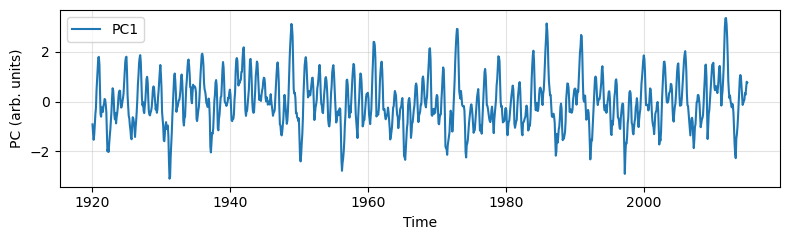

In [32]:
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.plot(out["time"].values, out["PCs"].sel(mode=1), label=f"PC1")
ax.legend()
ax.grid(True, alpha=0.35)
ax.set_xlabel("Time")
ax.set_ylabel("PC (arb. units)")
plt.tight_layout()
plt.show()
    

In [46]:
ds_out = xr.Dataset(
    data_vars={
        "PCs":    out["PCs"],      # (time, mode)
        "Nino34": out["nino34"],   # (time)
        "anoms":   out["anoms"],    # (time, lat, lon) anomalies used in EOFs
    }
)
ds_out.attrs.update({
    "title": " cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014 Projected PCs and Niño 3.4",
    "climatology_ref": "ERSSTv5: 1981-01 to 2010-12",
    "notes": "EOFs computed based on ERSSTv5, weights = sqrt(cos(lat))",
})

out_path = "../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014_pcs_nino34_1920_2014.nc"
ds_out.to_netcdf(out_path, format="NETCDF4", mode="w")
print(f"Saved to {out_path}")

Saved to ../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014_pcs_nino34_1920_2014.nc


### FCM

Classify the model data into regimes based on pseudo-PCs using the saved clustering model.

In [50]:
file = xr.open_dataset("../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014_pcs_nino34_1920_2014.nc")
data = file["PCs"].to_numpy()
nino34 = file["Nino34"].to_numpy()

with open('../data/fcm_ersstv5.pkl', 'rb') as f:
    fcm_model_data = pickle.load(f)
cluster_model = FCMEntropy(**fcm_model_data['config'])
cluster_model.centers = fcm_model_data['centers']
cluster_model.weights = fcm_model_data['weights']
scaler = fcm_model_data['scaler']

features = []
features.append(data)
features = np.concatenate(features, axis=1)
features = scaler.transform(features)
weights = cluster_model.predict(features)
labels = np.argmax(weights, axis=1)
new_labels, remap, means = reorder_labels_by_mean_nino34(nino34, labels)

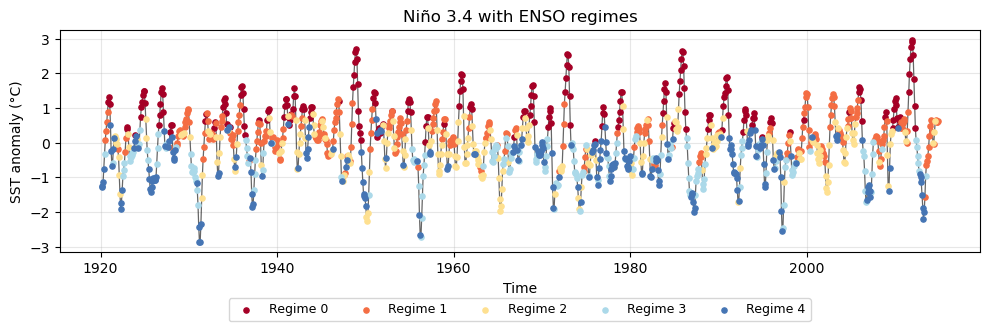

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

colors = [
    "#a50026",  # deep red
    "#f46d43",  # orange-red
    "#fee090",  # light orange
    "#abd9e9",  # light blue
    "#4575b4",  # deep blue
]
fig, ax = plot_nino34_with_regimes(
    nino34, new_labels, time=file["time"],  # times can be pandas.DatetimeIndex
    regime_names=["Regime 0", "Regime 1", "Regime 2", "Regime 3", "Regime 4"],
    colors=colors,
    title="Niño 3.4 with ENSO regimes"
)
plt.savefig('../figure/nino34_regimes_fcm_cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014.png')
plt.show()

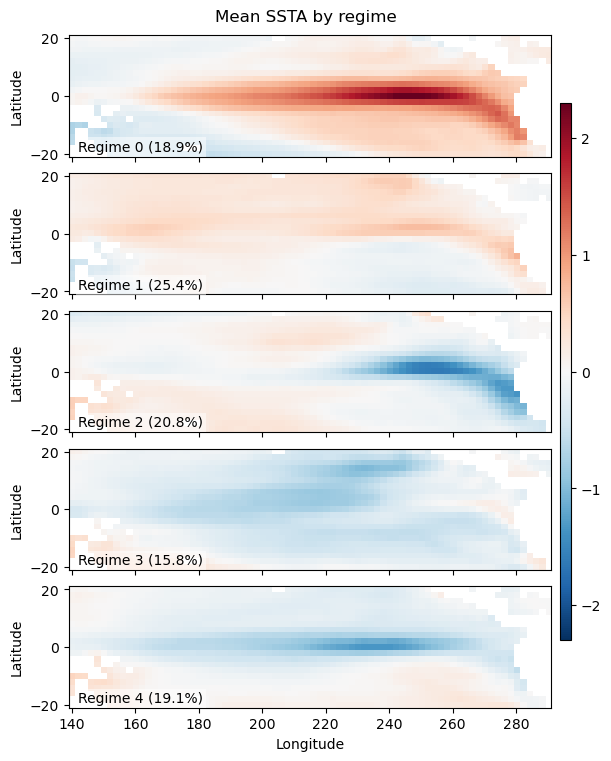

In [54]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def mean_anom_per_regime(anom: xr.DataArray, regime_ids):
    # Ensure time is the first dim (xarray's groupby alignment will use coords anyway)
    if anom.dims[0] != "time":
        anom = anom.transpose("time", ...)

    # Make a time-aligned DataArray of regime labels
    reg = xr.DataArray(
        np.asarray(regime_ids),
        coords={"time": anom["time"]},
        dims=["time"],
        name="regime"
    )

    # Group by regime and average over time
    mean_maps = anom.groupby(reg).mean("time")  # dims -> ('regime','lat','lon')

    # Make sure the regime dim is nicely named and sorted
    mean_maps = mean_maps.rename({"regime": "regime"}).sortby("regime")
    
    # Frequency per regime
    counts = reg.groupby(reg).count()           # -> (regime,)
    counts = counts.rename("count").sortby("regime")
    total  = int(reg.count().item())
    freq   = (counts / total).rename("freq")    # fraction in [0,1]

    return mean_maps, freq  # (regime, lat, lon)

def plot_five_regime_means(mean_maps: xr.DataArray, freq: xr.DataArray, regimes=None, cmap="RdBu_r"):
    """
    Plot five regime-mean anomaly maps with a shared symmetric color scale.
    If 'regimes' is None, the first five regimes in mean_maps.regime are used.
    """
    if regimes is None:
        regimes = mean_maps.regime.values[:5]
    sel = mean_maps.sel(regime=regimes)

    vmax = float(np.nanmax(np.abs(sel.values)))
    vmin = -vmax

    fig, axs = plt.subplots(
        len(regimes), 1, figsize=(6, 1.5*len(regimes)),
        sharex=True, constrained_layout=True
    )

    if len(regimes) == 1:
        axs = [axs]
        
    frq_map = {int(r): float(freq.sel(regime=r).item()) for r in freq.regime.values}

    for ax, reg in zip(axs, regimes):
        patt = sel.sel(regime=reg)
        im = patt.plot.imshow(
            ax=ax,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            add_colorbar=False
        )
        ax.set_ylabel("Latitude")
        if ax != axs[-1]:
            ax.set_xlabel("")
        else: 
            ax.set_xlabel("Longitude")
        ax.set_title("")  # remove any auto-generated title
        r = int(reg)
        frq = frq_map.get(r, 0.0) * 100.0
        ax.text(
            0.02, 0.02, f"Regime {reg} ({frq:.1f}%)",
            transform=ax.transAxes, fontsize=10,
            color="black", ha="left", va="bottom",
            bbox=dict(facecolor="white", alpha=0.5, edgecolor="none", pad=2)
        )

    cbar = fig.colorbar(im, ax=axs, orientation="vertical", aspect=50, shrink=0.8, fraction=0.1, pad=0.02)
    fig.suptitle("Mean SSTA by regime", fontsize=12)

mean_maps, freq = mean_anom_per_regime(file["anoms"], new_labels)
plot_five_regime_means(mean_maps, freq, regimes=[0,1,2,3,4])
plt.savefig('../figure/meanssta_regimes_fcm_cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014.png')
plt.show()

#### PCs check on obs data (projection to EOFs)

In [12]:
pcs_obs = compute_pcs(obs.sel(time=slice("1920-01", "2020-12"), lat=slice(20, -20), lon=slice(140, 290)), eof_file.sel(time=slice("1920-01", "2020-12")).EOFs, clim_ref=clim_ref_obs)  # where eofs_4 has dims (mode, lat, lon)

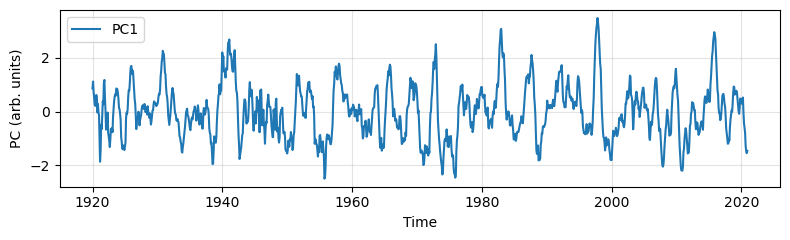

In [13]:
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.plot(pcs_obs["time"].values, pcs_obs.sel(mode=1), label=f"PC1")
ax.legend()
ax.grid(True, alpha=0.35)
ax.set_xlabel("Time")
ax.set_ylabel("PC (arb. units)")
plt.tight_layout()
plt.show()
    

#### PCA check (be careful about the sign)

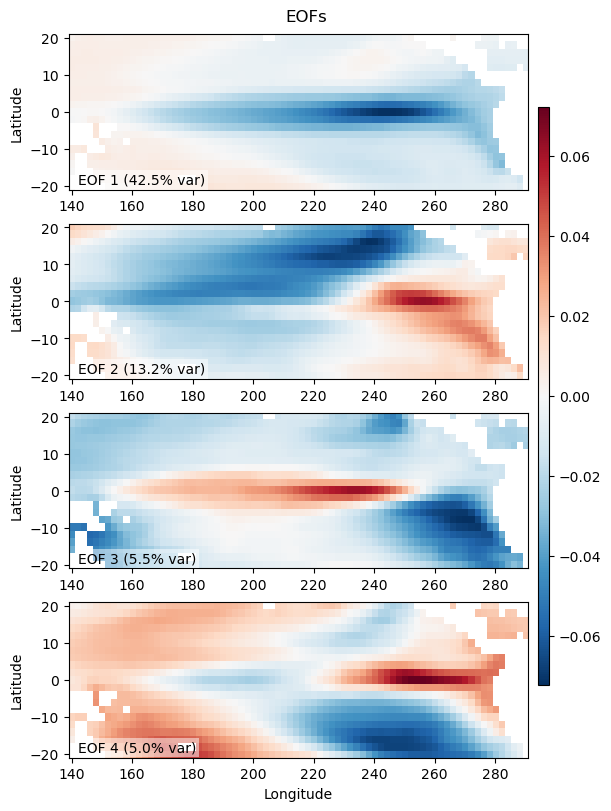

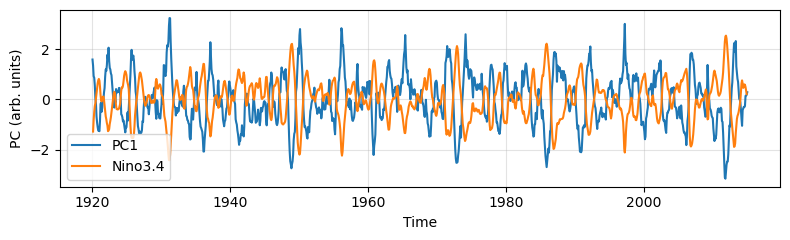

In [14]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import detrend as sp_detrend
import hvplot.xarray
import holoviews as hv
hv.extension('bokeh')
from eofs.xarray import Eof

def pca_ersstv5(
    da,
    time_slice=None,        # e.g. ("1900-01", "2024-12")
    lat_bounds=None,        # e.g. (60, -60)
    lon_bounds=None,        # e.g. (120, 290)   (0..360 in ERSST)
    remove_season=True,
    detrend_linear=True,
    n_modes=10,
    reorder_lat_ascending=False,
    nino=False,
    clim_ref=None,
):
    # Auto-rename latitude/longitude if needed
    rename_map = {}
    for old, new in [('latitude', 'lat'), ('longitude', 'lon')]:
        if old in da.dims or old in da.coords: rename_map[old] = new
    if rename_map:
        da = da.rename(rename_map)

    # ---- (Optional) reorder latitude to ascending; safer for weighting/plots ---
    if reorder_lat_ascending and (da.lat.values[0] > da.lat.values[-1]):
        da = da.sortby("lat")

    # ---- Subset time ----
    if time_slice is not None:
        da = da.sel(time=slice(*time_slice))

    # ---- Subset latitude ----
    if lat_bounds is not None:
        lo, hi = lat_bounds
        da = da.sel(lat=slice(lo, hi))

    # ---- Subset longitude ----
    if lon_bounds is not None:
        lo, hi = lon_bounds
        if lo <= hi:
            da = da.sel(lon=slice(lo, hi))
        else:
            # wrap-around case, e.g. (300, 60)
            da = xr.concat(
                [da.sel(lon=slice(lo, 360)), da.sel(lon=slice(0, hi))],
                dim="lon"
            )

    # ---- Remove seasonal cycle (monthly climatology) ----
    if remove_season:
        if clim_ref is None:
            clim = da.groupby("time.month").mean("time")
        elif isinstance(clim_ref, xr.DataArray):
            clim = clim_ref
        else:
            ref = da.sel(time=slice(*clim_ref)) # Select the reference period for climatology
            if ref.time.size == 0:
                raise ValueError(f"clim_ref range {clim_ref} has no overlap with data.")
            clim = ref.groupby("time.month").mean("time") # Compute monthly climatology over the reference period
        anoms = da.groupby("time.month") - clim # Subtract monthly climatology from all time steps
    else:
        anoms = da        

    # ---- (Optional) linear detrend per grid cell ----
    if detrend_linear:
        def _detrend_1d(x):
            if np.all(np.isnan(x)):
                return x
            return sp_detrend(x, type="linear")
        anoms = xr.apply_ufunc(
            _detrend_1d, anoms,
            input_core_dims=[["time"]],
            output_core_dims=[["time"]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[anoms.dtype]
        )

    # ---- (Optional) Nino 3.4 ----
    if nino == True:
        nino34_xy = anoms.sel(lat=slice(5, -5), lon=slice(190, 240))
        nino34_mean = nino34_xy.mean(dim=('lon', 'lat'))
        nino34 = nino34_mean.rolling(time=3, center=True).mean()
    else:
        nino34 = None
    
    # ---- Area weights: sqrt(cos(lat))  (broadcast over lon) ----
    lat_rad = np.deg2rad(anoms["lat"])
    w_lat = np.sqrt(np.cos(lat_rad))
    w2d = w_lat.broadcast_like(anoms.isel(time=0)) # Expand to 2D (lat, lon) for clean broadcasting
    
    # anoms_w = anoms * w2d
    # anoms_w = anoms_w[:, np.isfinite(anoms_w).all("time")]
    # anoms_w.mean(dim=['lon', 'lat']).plot(label='detrended')
    # plt.grid()
    # plt.legend()

    solver = Eof(anoms.transpose("time", "lat", "lon"), weights=w2d)
    EOFs = solver.eofs(neofs=n_modes)
    PCs = solver.pcs(npcs=n_modes, pcscaling=1)
    evrs = solver.varianceFraction()
    EOFs = EOFs.assign_coords(mode=np.arange(1, EOFs.sizes["mode"]+1))

    out = {
        "EOFs": EOFs,  # [mode, lat, lon] in °C units
        "PCs": xr.DataArray(PCs, coords={"time": anoms["time"], "mode": np.arange(1, n_modes+1)}, dims=["time","mode"]),
        "evrs": xr.DataArray(evrs[:n_modes], coords={"mode": np.arange(1, n_modes+1)}, dims=["mode"]),
        # "singular_values": s[:k],
        "anoms": anoms,
        "lat": anoms["lat"],
        "lon": anoms["lon"],
        "time": anoms["time"],
        "nino34": nino34,
    }
    return out

def plot_eofs(eofs, evr, modes=(1,2,3), vmin=None, vmax=None):
    modes = list(modes)
    fig, axs = plt.subplots(len(modes), 1, figsize=(6, 2*len(modes)), constrained_layout=True)
    if len(modes) == 1: axs = [axs]
    for ax, m in zip(axs, modes):
        patt = eofs.sel(mode=m)
        patt = patt.sortby("lat")
        im = patt.plot.imshow(
            ax=ax, cmap="RdBu_r", vmin=vmin, vmax=vmax,
            add_colorbar=False
        )
        ax.set_title("")
        ax.text(
            0.02, 0.02, f"EOF {m} ({evr.sel(mode=m).item()*100:.1f}% var)",
            transform=ax.transAxes, fontsize=10,
            color="black", ha="left", va="bottom",
            bbox=dict(facecolor="white", alpha=0.5, edgecolor="none", pad=2)
        )
        if ax != axs[-1]:
            ax.set_xlabel("")
        else: 
            ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

    cbar = fig.colorbar(im, ax=axs, orientation="vertical", aspect=50, shrink=0.8, fraction=0.1, pad=0.02)
    fig.suptitle("EOFs", fontsize=12)
    
def plot_pcs(pcs, modes=(1,2,3), nino=None):
    fig, ax = plt.subplots(figsize=(8, 2.5))
    for m in modes:
        ax.plot(pcs["time"].values, pcs.sel(mode=m), label=f"PC{m}")
    if nino is not None:
        ax.plot(nino["time"].values, nino, label=f"Nino3.4")
    ax.legend()
    ax.grid(True, alpha=0.35)
    ax.set_xlabel("Time")
    ax.set_ylabel("PC (arb. units)")
    plt.tight_layout()
    plt.show()
    
if __name__ == "__main__":
    res = pca_ersstv5(
        ds_2deg.sst.sel(time=slice("1920-01", "2014-12")),
        time_slice=("1920-01", "2014-12"),
        lat_bounds=(20, -20),
        lon_bounds=(140, 290),
        remove_season=True,
        detrend_linear=True,
        n_modes=4,
        nino=True,
        clim_ref=("1981-01", "2010-12"),
    )

    plot_eofs(res["EOFs"], res["evrs"], modes=(1,2,3,4))
    # plt.savefig('../figure/eofs.png')
    plot_pcs(res["PCs"], modes=(1,), nino=res['nino34'])

In [38]:
modes_flip = [0,2,3]
for mode in modes_flip:
    res["EOFs"][mode] = -res["EOFs"][mode]
    res["PCs"][:, mode] = -res["PCs"][:, mode]

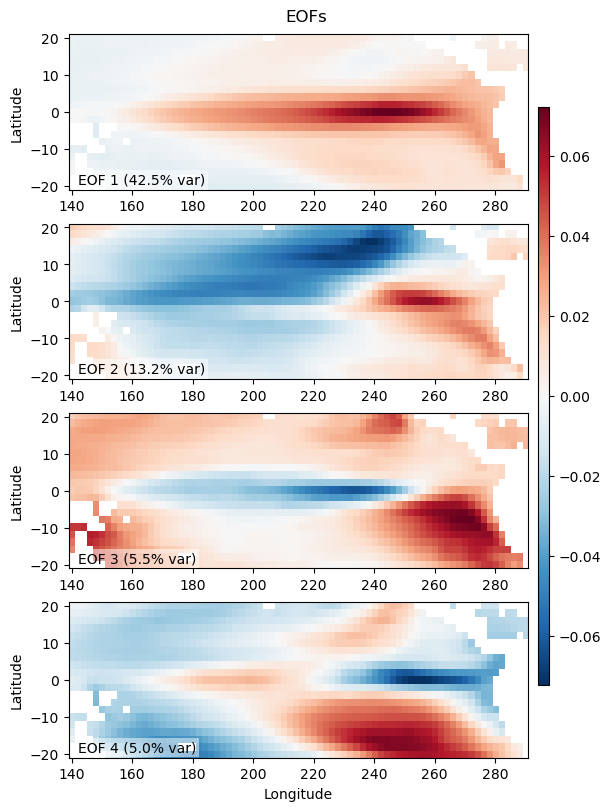

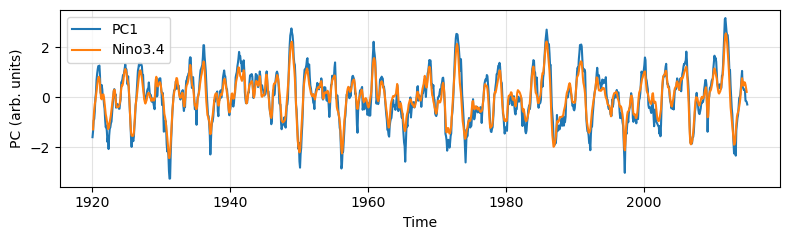

In [39]:
plot_eofs(res["EOFs"], res["evrs"], modes=(1,2,3,4))
# plt.savefig('../figure/eofs.png')
plot_pcs(res["PCs"], modes=(1,), nino=res['nino34'])

## Modeling